In [28]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    fbeta_score, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay
)

In [2]:
df = pd.read_csv('../data/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The `shape` attribute shows us the number of observations and the number of features in the dataset

In [3]:
df.shape

(768, 9)

The `info()` method shows that the data set does not have any features with missing values. It further shows that all features are numeric as well.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Using the `train_test_split()` function we will split our data set with 70% going to train the model and 30% going towards testing the model.

In [5]:
train_df, test_df = train_test_split(df,
                                     train_size = 0.7, 
                                     random_state=123)

The `describe()` shows us the summary statistics of each of our features as well as our target value. We can see the mean as well as the spread (standard deviation). Using this information and the visualization tools we will see next we can determine how skewed each of our features are for their respective values.

In [6]:
census_summary = train_df.describe()
census_summary

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000,537.000000
mean,3.810056,120.337058,69.247672,20.702048,81.960894,32.091806,0.463048,33.344507,0.335196
std,3.318488,31.744549,18.874886,15.677625,116.475625,7.562070,0.331082,11.851165,0.472499
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.200000,0.237000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,37.000000,32.000000,0.366000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,33.000000,128.000000,36.600000,0.600000,41.000000,1.000000
max,15.000000,199.000000,122.000000,63.000000,744.000000,59.400000,2.420000,81.000000,1.000000


In [7]:
features = census_summary.columns.tolist()
features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [8]:
feature_histograms = alt.Chart(train_df).transform_calculate(
    Diabetes_Label="datum.Outcome == 0 ? 'Non-Diabetic' : 'Diabetic'"
).mark_bar().encode( x = alt.X(alt.repeat()).type(
'quantitative').bin(maxbins=30), y= 'count()', color = 'Outcome:N'
).properties( height=250,
width=250 ).facet(
    column=alt.Column('Diabetes_Label:N', title='Diabetes Status')).repeat(
features, columns=1
)

feature_histograms 

alt.RepeatChart(...)

The Graphs above shows us the respective distribution of each of the features. We have faceted the results to show the how distribution of each feature is when the Outcome is 0 (Non-Diabetic) and when the Outcome is 1 (Diabetic). This helps give us an indication on certain relationships between the features and the target.

For example for the Glucose level feature, we see for Non-Diabetic's glucose levels are a somewhat normal distribution; but for the Diabetic class, the glucose levels lean heavily towards the middle to higher range. BMI for the Diabetic class looks like a normal distribution, but it also skews slighty to higher values. Where for the Non-Diabetic class interestingly the distribution seems more bimodal.

Here we further split our data set into our X and y for both the training and test

In [9]:
X_train = train_df.drop(columns = ['Outcome'])
y_train = train_df['Outcome']
X_test = test_df.drop(columns = ['Outcome'])
y_test = test_df['Outcome']

We will be using a Logistic Regression model to do our classification. Since our features have outliers it would be best to use a StandardScaler() to normalize the feature values before fitting the model to them.

In [10]:
log_pipe=make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000,
random_state=123))

We optimze the hyperparamter 'C' for our logistic regression using a random search

In [11]:
np.random.seed(123)
param_dist = {
    "logisticregression__C": [10**i for i in range(-3,4)] 
}

In [12]:
random_search = RandomizedSearchCV(log_pipe,param_dist,
                                   n_iter=7,
                                   n_jobs=-1,
                                   return_train_score=True,
                                   random_state=123)

random_search.fit(X_train,y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('logisticregression',
                                              LogisticRegression(max_iter=2000,
                                                                 random_state=123))]),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'logisticregression__C': [0.001, 0.01,
                                                                  0.1, 1, 10,
                                                                  100, 1000]},
                   random_state=123, return_train_score=True)

We find out best parameter value for our hyperparameter `C` that we will use in our model

In [13]:
best_params = random_search.best_params_ 
best_params

{'logisticregression__C': 10}

In [14]:
pd.DataFrame(random_search.cv_results_).sort_values(
    "rank_test_score").head(7)[["mean_test_score",
                                "mean_train_score"]]

,mean_test_score,mean_train_score
4,0.761717,0.771416
5,0.761717,0.771416
6,0.761717,0.771416
3,0.759848,0.770019
2,0.757961,0.766764
1,0.743077,0.749068
0,0.664798,0.664804


Having determined the best Logistic Regression model for our analysis, we further explore feature importance with coefficients.

[NEED TO UPDATE ALONG WITH MODEL CHANGE] The feature importance coefficients for the logistic regression model predicting diabetes reveal that `Glucose` (1.08) is the strongest positive influence, followed by `BMI` (0.72) and `Pregnancies` (0.39). The negative influences `BloodPressure` (-0.21) and `Insulin` (-0.20) along with the remaining postive features `DiabetesPedigreeFunction` (0.29), `Age` (0.12), and `SkinThickness` (0.04), have a moderate to weak impact on the prediction, with their effects being less pronounced. 

In [42]:
# Best model from the search
best_model = random_search.best_estimator_

# Retrieve the coefficients and feature names
coefficients = best_model.named_steps['logisticregression'].coef_.flatten()
features = X_train.columns  

# Create a DataFrame to display the feature names and corresponding coefficients
coeff_df = pd.DataFrame({
    'Features': features,
    'Coefficients': coefficients
})

# Sort by 'Coefficients' in descending order to see the most important features first
coeff_df_sorted = coeff_df.sort_values(by = 'Coefficients', ascending = False)

# Create a heatmap for the coefficients (we will visualize them as a single column)
coeff_df_sorted.style.format(
    precision = 2
).background_gradient(
    axis = None,
    cmap = 'RdBu_r',
    low = 0
)

,Features,Coefficients
1,Glucose,1.08
5,BMI,0.72
0,Pregnancies,0.39
6,DiabetesPedigreeFunction,0.29
7,Age,0.12
3,SkinThickness,0.04
4,Insulin,-0.20
2,BloodPressure,-0.21


We then perform best Logistic Regression model from hyperparameter search on the test set.

Our prediction model performed decent on test data, with a final overall accuracy of 0.80 and F2 (beta = 2) score of 0.67. [NEED TO EDIT FURTHER WITH CHANGE IN HYPERPARAMETER TUNING In addition, looking through the confusion matrix, there are a total of 46 mistakes. Of which, 31 mistakes were predicting diabetic as non-diabetic (false negatives) and 15 mistakes were made predicting diabetic as non-diabetic (false positives). Considering implementation in clinic, there is room for improvement in the algorithm as false negatives are more harmful than false positives, and we should aim to lower false positives even further.]

In [17]:
# Make predictions using the best model
y_pred = best_model.predict(X_test)

# Compute accuracy
accuracy = best_model.score(X_test, y_test)

# Compute F2 score (beta = 2)
f2_score = fbeta_score(y_test, y_pred, beta = 2, pos_label = 1)

pd.DataFrame({'accuracy': [accuracy], 'F2 score (beta = 2)': [f2_score]})

,accuracy,F2 score (beta = 2)
0,0.800866,0.67217


In [26]:
# Confusion matrix result and display
confusion_matrix(y_test, y_pred)

array([[128,  15],
       [ 31,  57]], dtype=int64)

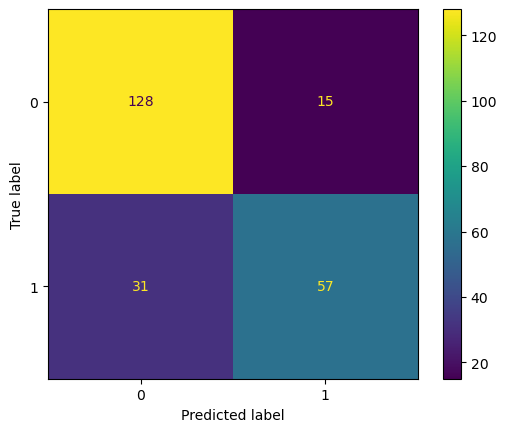

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In addition, we explore the precision-recall curve with average precision (AP) score and ROC curve with AUC to sweep through different threshold and identify whether a different threshold would result in a better model. 

[ADD FINDINGS UPON MODEL REFINED]

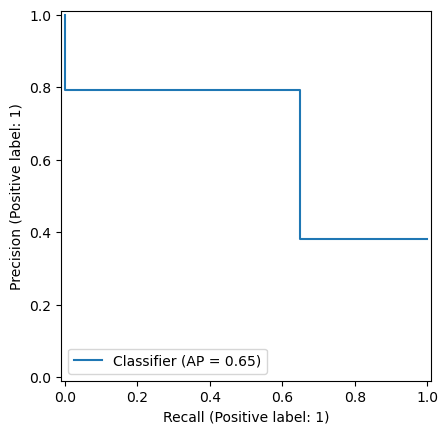

In [30]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred, pos_label = 1)

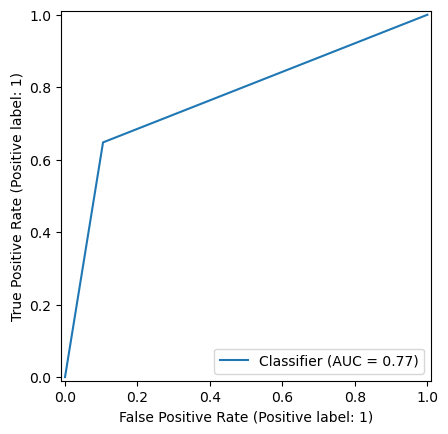

In [31]:
RocCurveDisplay.from_predictions(y_test, y_pred, pos_label = 1)

[FURTHER ADJUST BASED ON RESULTS AND UPDATED ANALYSIS] While the performance of this model could be useful as a screening tool in a clinical setting, [particularly considering its improvements to baseline], there are several directions that could be explored for to improve it further. 

First, we could look closely at the 46 misclassified observations and compare them to several observations that were classified correctly (from both classes). The goal of this would be to see which feature(s) may be driving the misclassification and explore whether any feature engineering could be used to help the model better predict on observations that it currently is making mistakes on. 

Additionally, we would try seeing whether we can get improved predictions using other classifiers. Other classifiers we might try are 1) random forest because it automatically allows for feature interaction, 2) k-nearest neighbours (k-NN) which usually provides easily interpretable and decent predictions, and 3) support vector classifier (SVC) as it allows for non-linear prediction using the rbf kernel. 

Moreover, there runs the possibility that the features offered from this dataset alone are not sufficient to predict with high accuracy. In this case, conducting additional conversations with data collectors for additional useable information or explore additional datasets that can be joined so our set of features can be expanded for more complicated analysis might be beneficial. 

[PARAPHRASE IF USE Finally, we also might improve the usability of the model in the clinic if we output and report the probability estimates for predictions. If we cannot prevent misclassifications through the approaches suggested above, at least reporting a probability estimates for predictions would allow the clinician to know how confident the model was in its prediction. Thus the clinician may then have the ability to perform additional diagnostic assays if the probability estimates for prediction of a given tumour class is not very high.]